In [55]:
# import some packages

import nltk
from nltk.corpus import words
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
from english_words import english_words_lower_alpha_set
import seaborn as sns
sns.set_style("darkgrid")

# Import word lists

## We have two choices:

In [56]:
word_list = english_words_lower_alpha_set
print(len(word_list)) # this contains only 25k words

word_list = words.words()
print(len(word_list)) # this word list contains many more words

25463
236736


## Filter only for 5 letter words

In [57]:
# get 5 letter words from word_list
five_letter_words = [w for w in word_list if len(w) == 5]
# convert all words to lower case
five_letter_words = [w.lower() for w in five_letter_words]
len(five_letter_words)

10422

In [58]:
# read in text file coma delimiter
text_file = open("wordl_word_list.txt", "r")
word_word_list = text_file.read()
word_word_list = word_word_list.split(",")
text_file.close()
print(len(word_word_list))

five_letter_words = word_word_list

12972


We have 10k 5-letter words

## Calculate letter frequency

(maybe it would be better to calculate letter/word freq)

In [59]:
#concat a list of words to a string
def concat_list_to_string(list_of_words):
    return ''.join(list_of_words)
    
one_string = concat_list_to_string(five_letter_words)

def char_frequency(str1):
    dict = {}
    for n in str1:
        keys = dict.keys()
        if n in keys:
            dict[n] += 1
        else:
            dict[n] = 1
    return dict
    
char_freq = char_frequency(one_string)

char_freq_sorted = dict(sorted(char_freq.items(), key=lambda item: item[1], reverse=True))

This is the letter frequency for each letter:

In [60]:
char_freq_sorted

{'s': 6665,
 'e': 6662,
 'a': 5991,
 'o': 4438,
 'r': 4158,
 'i': 3759,
 'l': 3371,
 't': 3295,
 'n': 2952,
 'u': 2511,
 'd': 2453,
 'y': 2074,
 'c': 2028,
 'p': 2019,
 'm': 1976,
 'h': 1760,
 'g': 1644,
 'b': 1627,
 'k': 1505,
 'f': 1115,
 'w': 1039,
 'v': 694,
 'z': 434,
 'j': 291,
 'x': 288,
 'q': 112,
 ']': 1,
 'T': 1,
 '=': 1,
 '[': 1}

## Calculate a "score for each letter what we can use later to be able to chose next words more efficiently

In [61]:
# for each word in a list calculate letter score
def letter_score(word):
    score = 0
    letter_list = []
    for letter in word:
        if letter not in letter_list:
            score += char_freq_sorted[letter]
        letter_list.append(letter)
    return score

In [62]:
letter_score_list = [letter_score(w) for w in five_letter_words]
# create a dataframe with word and score
df_word_score = pd.DataFrame({'word': five_letter_words, 'score': letter_score_list})
# sort by score
df_word_score = df_word_score.sort_values(by=['score'], ascending=False).reset_index(drop=True)
df_word_score['unique_letters'] = df_word_score['word'].apply(lambda x: len(set(x)))
#drop duplicates
df_word_score = df_word_score.drop_duplicates(subset=['word'], keep='first').reset_index(drop=True)

## Top words based on letter score

In [63]:
df_word_score[0:20]

,word,score,unique_letters
0,soare,27914,5
1,aeros,27914,5
2,arose,27914,5
3,aesir,27235,5
4,serai,27235,5
5,arise,27235,5
6,raise,27235,5
7,reais,27235,5
8,aloes,27127,5
9,stoae,27051,5


# Import all possible solutions based on Wordl word lists that can be found in the source code of Wordl

In [64]:
solution_list = pd.read_csv("words.csv")
solution_list = solution_list['word']
solution_list.tolist()
len(solution_list)

2315

# Write the actual Wordl game

In [65]:
def play_game(solution = 'random', solution_list = solution_list, five_letter_words_list = five_letter_words,
                player_play = False, starting_guess = 'random', silence = False, word_table = df_word_score, strategy = 1):

    top_words_table = word_table.copy()
    five_letter_words_list = five_letter_words_list.copy()

    if not silence:
        print('choosing from this many words: ', len(five_letter_words_list))

    # get a random word from the list. This is the word that we need to figure out
    if solution == 'random':
        solution = random.choice(list(solution_list))
        
        
    board = ["-"] * 5 * 6
    score_board = ["0"] * 5 * 6
    score_list = []

    green_score = '2'
    yellow_score = '1'
    black_score = '-1'


    # print the empty board and score_board
    if not silence:
        print(board)
        print(score_board)
    
    def play_one_chance():

        # get the player to enter a letter
        if player_play:

            word_input = input("Enter a word: ")

        else:

            how_many_dash = board.count('-')

            # do this at the 1st round
            if starting_guess == 'random' and how_many_dash == 30:
                #random chose from five_letter_words_list
                word_input = random.choice(list(five_letter_words_list))

            elif starting_guess != 'random' and how_many_dash == 30:
                word_input = starting_guess
            
            # when we are not the 1st round
            elif how_many_dash < 30:

                # this part can be much more efficiently written
                # right now in every round i check each letter from beginning to the end of the previous rounds too
                # there is no need to to check the letters that were already played because we can check them when they are played

                for i in range(len(score_board) - how_many_dash):

                    if score_board[i] == green_score:
                        for word in five_letter_words_list:
                            if word[i % 5] != board[i]:
                                five_letter_words_list.remove(word)

                    if score_board[i] == yellow_score:
                        for word in five_letter_words_list:

                            if board[i] not in word:
                                five_letter_words_list.remove(word)

                            if word[i % 5] == board[i]:
                                five_letter_words_list.remove(word)
                        
                    
                    if score_board[i] == black_score:
                        for word in five_letter_words_list:
                            if board[i] in word:
                                five_letter_words_list.remove(word)

                # choose the next word
                if strategy == 1:
                    #concat a list of words to a string
                    def concat_list_to_string(list_of_words):
                        return ''.join(list_of_words)
                        
                    one_string = concat_list_to_string(five_letter_words_list)

                    def char_frequency(str1):
                        dict = {}
                        for n in str1:
                            keys = dict.keys()
                            if n in keys:
                                dict[n] += 1
                            else:
                                dict[n] = 1
                        return dict
                        
                    char_freq = char_frequency(one_string)

                    char_freq_sorted = dict(sorted(char_freq.items(), key=lambda item: item[1], reverse=True))                  

                    #concat a list of words to a string
                    def concat_list_to_string(list_of_words):
                        return ''.join(list_of_words)
                        
                    one_string = concat_list_to_string(five_letter_words_list)

                    def char_frequency(str1):
                        dict = {}
                        for n in str1:
                            keys = dict.keys()
                            if n in keys:
                                dict[n] += 1
                            else:
                                dict[n] = 1
                        return dict
                        
                    char_freq = char_frequency(one_string)

                    char_freq_sorted = dict(sorted(char_freq.items(), key=lambda item: item[1], reverse=True))

                    # for each word in a list calculate letter score
                    def letter_score(word):
                        score = 0
                        letter_list = []
                        for letter in word:
                            if letter not in letter_list:
                                score += char_freq_sorted[letter]
                            letter_list.append(letter)
                        return score
                        

                    letter_score_list = [letter_score(w) for w in five_letter_words_list]
                    # create a dataframe with word and score
                    df_word_score = pd.DataFrame({'word': five_letter_words_list, 'score': letter_score_list})
                    # sort by score
                    df_word_score = df_word_score.sort_values(by=['score'], ascending=False).reset_index(drop=True)
                    df_word_score['unique_letters'] = df_word_score['word'].apply(lambda x: len(set(x)))
                    #drop duplicates
                    df_word_score = df_word_score.drop_duplicates(subset=['word'], keep='first').reset_index(drop=True)

                    #word_input = random.choice(list(five_letter_words_list))
                    word_input = df_word_score['word'][0]

                if strategy == 2:
                    
                    max_word_to_choose_score = 0
                    new_word = random.choice(list(five_letter_words_list))

                    for word in five_letter_words_list:
                        
                        word_to_choose_score = 0

                        for word2 in five_letter_words_list:
                            
                            letters_in_word = []

                            for one_letter in range(len(word)):
                                if word[one_letter] in word2 and word[one_letter] not in letters_in_word:
                                    word_to_choose_score = word_to_choose_score + 1
                                letters_in_word.append(word[one_letter])

                        if word_to_choose_score > max_word_to_choose_score:
                            #print(word)
                            max_word_to_choose_score = word_to_choose_score
                            new_word = word
                        
                    word_input = new_word

                if strategy == 3:
                    word_input = random.choice(list(five_letter_words_list))


        if not silence:
            print('choosing from this many words: ', len(five_letter_words_list))


        if word_input in five_letter_words_list:
            
            if not silence:
                print("Five letter word found as input!")
                
            return(word_input)
        else:
            
            if not silence:
                print("No five letter word found as input! Give something else!")
            
            return(play_one_chance())

    def update_board(board,i,word_input):
        board[(i * 5):(5 + i * 5)] = word_input
        return(board)

    def update_score_board(score_board,i,word_input):
        score_board[(i * 5):(5 + i * 5)] = [green_score if (word_input[w] in solution and  word_input[w]==solution[w]) else 
                                            yellow_score if (word_input[w] in solution and word_input[w]!=solution[w]) else
                                            black_score for w in range(5)]
        return(score_board)

    for i in range(6):

        if not silence:
            print('### Round: ', i + 1, ' ###')

        word_input = play_one_chance()
        
        if not silence:
            print('Given word: ', word_input)

        if word_input == solution:
            if not silence:
                print("Solution found!")
            # convert string to list
            word_input = list(word_input)

            board = update_board(board,i,word_input)
            score_board = update_score_board(score_board,i,word_input)

            #calculate score
            score_new = list(map(int, score_board))
            score_new_total = 0
            for numbers in score_new:
                score_new_total = score_new_total + numbers
            score_list.append(score_new_total)

            if not silence:
                print(board)
                print(score_board)
            player_won = True
            break
        else:
            if not silence:
                print("Solution not found!")
            # convert string to list
            word_input = list(word_input)

            board = update_board(board,i,word_input)
            score_board = update_score_board(score_board,i,word_input)

            #calculate score
            score_new = list(map(int, score_board))
            score_new_total = 0
            for numbers in score_new:
                score_new_total = score_new_total + numbers
            score_list.append(score_new_total)
            if not silence:
                print(board)
                print(score_board)
            player_won = False


    if player_won == False:
        if not silence:
            print("Game over you lost!")
        score_list.append(-100)
        score_list.append(-100)
        won = 0
    if player_won == True:
        if not silence:
            print("You won!")
        score_list.append(100)
        won = 1
    
    total_score = sum(score_list)
    
    if not silence:
        print("The solution was: " + solution)
        print("It took: " + str(len(score_list) - 1) + " rounds")
        print("Total score: ", total_score)
        print("Score list: ", score_list)

    return(won, (len(score_list) - 1))



# Play the game

Using this function the we or the "AI" can pay the game. If you run the function like this the AI will play. But if you set the 'player_play' argument to True you can try it out yourself.

In [66]:
play_game(player_play=False, solution = 'random', five_letter_words_list = five_letter_words, starting_guess='sound', silence=False, strategy=1)

choosing from this many words:  12972
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
### Round:  1  ###
choosing from this many words:  12972
Five letter word found as input!
Given word:  sound
Solution not found!
['s', 'o', 'u', 'n', 'd', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
['-1', '-1', '-1', '-1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
### Round:  2  ###
choosing from this many words:  2816
Five letter word found as input!
Given word:  redia
Solution not found!
['s', 'o', 'u', 'n', 'd', 'r', 'e', 'd', 'i', 'a', '-', '-', '-', '-', '-', '-', '-', '-', '-', '

(1, 5)

# Simulate games
In this case 1000 times

In [67]:
times = 1000
starting_word = 'sound'

100%|██████████| 1000/1000 [09:49<00:00,  1.70it/s]


Win ratio:  0.762
Avarage rounds to solve:  5.746


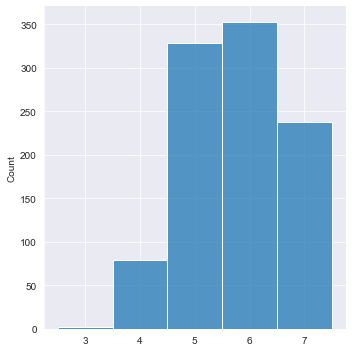

In [68]:
won_list = []
score_list = []

for i in tqdm(range(times)):
    w, s = play_game(solution = 'random', five_letter_words_list = five_letter_words, starting_guess=starting_word, silence=True, strategy=3)
    won_list.append(w)
    score_list.append(s)

won_list = np.array(won_list)
score_list = np.array(score_list)
# mean of numpy array
print("Win ratio: ",np.mean(won_list))
print("Avarage rounds to solve: ",np.mean(score_list))

sns.displot(x=score_list, bins=[0, 1, 2, 3, 4, 5, 6, 7], discrete=True)

100%|██████████| 1000/1000 [10:05<00:00,  1.65it/s]

Win ratio:  0.926
Avarage rounds to solve:  4.942


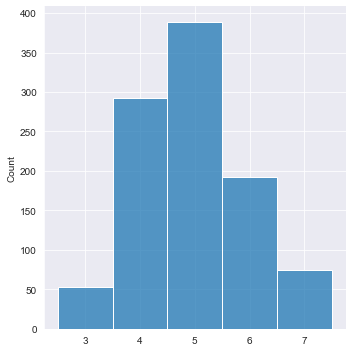

In [69]:
won_list = []
score_list = []

for i in tqdm(range(times)):
    w, s = play_game(solution = 'random', five_letter_words_list = five_letter_words, starting_guess=starting_word, silence=True, strategy=1)
    won_list.append(w)
    score_list.append(s)

won_list = np.array(won_list)
score_list = np.array(score_list)
# mean of numpy array
print("Win ratio: ",np.mean(won_list))
print("Avarage rounds to solve: ",np.mean(score_list))


sns.displot(x=score_list, bins=[0, 1, 2, 3, 4, 5, 6, 7], discrete=True)
# 7 means game over

100%|██████████| 1000/1000 [5:12:45<00:00, 18.77s/it] 


Win ratio:  0.926
Avarage rounds to solve:  4.877


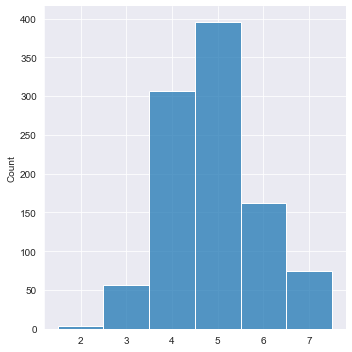

In [70]:
won_list = []
score_list = []

for i in tqdm(range(times)):
    w, s = play_game(solution = 'random', five_letter_words_list = five_letter_words, starting_guess=starting_word, silence=True, strategy=2)
    won_list.append(w)
    score_list.append(s)

won_list = np.array(won_list)
score_list = np.array(score_list)
# mean of numpy array
print("Win ratio: ",np.mean(won_list))
print("Avarage rounds to solve: ",np.mean(score_list))


sns.displot(x=score_list, bins=[0, 1, 2, 3, 4, 5, 6, 7], discrete=True)
# 7 means game over